# Pulse stream recovery for arbitrary pulse shapes (noiseless)

In the previous notebook, we saw an example of recovering the pulse localtions and amplitudes for a signal of the following structure, after it has gone through the necessary sampling kernel and sampling:

\begin{align}
y(t) = \sum_{n\in\mathbb{Z}}\sum_{k=0}^{K-1}c_k \hspace{0.05cm} \delta(t-t_k-nT).  \nonumber
\end{align}

In [1]:
import numpy as np
import sys
sys.path.append('..')
import plot_settings
from frius import create_pulse_param, sample_ideal_project, estimate_fourier_coeff, compute_ann_filt, estimate_time_param, estimate_amplitudes

# 1. Extension to arbitrary pulse shape

We now consider the situation in which our pulse shape may not be a Dirac. Similarly, our sampling kernel may not have a _flat_ response over its frequency support. This implies that we can "group" the pulse and the sampling kernel into a single function, which we will still denote by $h(t)$:

\begin{align}
y(t) = \sum_{n\in\mathbb{Z}}\sum_{k=0}^{K-1}c_k \hspace{0.05cm} h(t-t_k-nT). \nonumber
\end{align}

Our measured samples are then obtained from this signal which combines our pulse _and_ the effect of our sampling kernel. 

Consequently, our recovery process requires knowledge about $h(t)$. In the previous notebook, we saw the following steps for recoverying the parameters of a _Dirac_ stream after it has gone through an ideal sampling kernel with a flat response:

1. With the samples, estimate the Fourier coefficients with the DFT.
2. From the Fourier coefficients, obtain the annihilating filter, i.e. the mask with zeros that coincide with the zeros of the Dirac stream.
3. Find the $K$ zeros of the mask corresponding to the annihilating filter. This will yield the locations $\{t_k\}_{k=0}^{K-1}$.
4. With the locations and measured samples, solve a least-squares for the pulse amplitudes $\{c_k\}_{k=0}^{K-1}$.

Please refer to [1] for a more detailed mathematical description.

For an arbitrary pulse shape, we need to remove the combined pulse and sampling effect; otherwise it will not be possible to determine an annihilating filter from the Fourier coefficients! This entails an additional step in our "mapping" phase before obtaining the annihilating filter:

1. With the samples, estimate the Fourier coefficients with the DFT.
2. Remove the effect of the pulse and/or sampling kernel from the estimated Fourier coefficients.
2. From the resulting Fourier coefficients, obtain the annihilating filter, i.e. the mask with zeros that coincide with the zeros of the Dirac stream.
3. Find the $K$ zeros of the mask corresponding to the annihilating filter. This will yield the locations $\{t_k\}_{k=0}^{K-1}$.
4. With the locations and measured samples, solve a least-squares for the pulse amplitudes $\{c_k\}_{k=0}^{K-1}$.

This additional step is often called **_equalization_**, as we are trying to "equalize" or balance out the level across frequencies. In the [Appendix](#app), we provide a more mathematical reasoning as to why this equalization step is necessary.

# 2. Example with code

We now consider a small example where either our pulse has a Gaussian shape and our sampling kernel is still an ideal lowpass filter with bandwidth $B=2K$.

We first define a function to compute the frequency response of our Gaussian shape [2]:

In [2]:
def gaus_ft(freqs, alpha=1e4):
    return np.sqrt(np.pi/alpha) * np.exp( (np.pi*freqs)*(np.pi*freqs)/alpha )

We can then pass this function to our sampling utility.

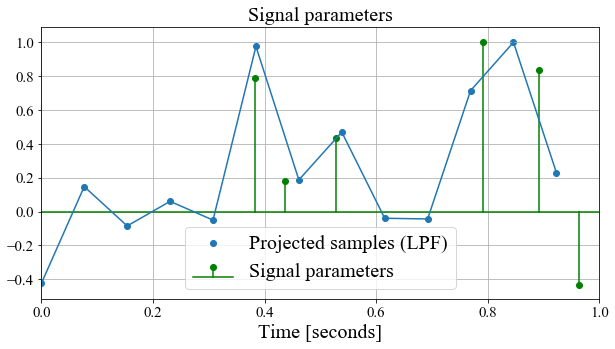

In [3]:
K = 6
period = 1
ck, tk = create_pulse_param(K=K, period=period)
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, H=gaus_ft, viz=True, figsize=(10,5))

We first try to perform the recovery **_without_** the equalization step.

In [4]:
freqs = fs_ind_base/period
fs_coeff_hat = estimate_fourier_coeff(y_samp, t_samp)
ann_filt = compute_ann_filt(fs_coeff_hat, K)
tk_hat = estimate_time_param(ann_filt, period)
tk_hat = np.sort(tk_hat)                                     # sort for comparison as `tk` are sorted
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

print("||tk - tk_hat||_2 = %f " % np.linalg.norm(tk-tk_hat))
print("||ck - ck_hat||_2 = %f " % np.linalg.norm(ck-ck_hat))

||tk - tk_hat||_2 = 0.006075 
||ck - ck_hat||_2 = 3.632765 


We can observe that we are not able to recover the pulse locations precisely, and this also affects the recovery of the amplitudes! We now perform the recovery **_with_** the equalization step.

In [5]:
freqs = fs_ind_base/period
fs_coeff_hat = estimate_fourier_coeff(y_samp, t_samp)
fs_coeff_hat /= gaus_ft(freqs)                               # equalization step
ann_filt = compute_ann_filt(fs_coeff_hat, K)
tk_hat = estimate_time_param(ann_filt, period)
tk_hat = np.sort(tk_hat)                        
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

print("||tk - tk_hat||_2 = %f " % np.linalg.norm(tk-tk_hat))
print("||ck - ck_hat||_2 = %f " % np.linalg.norm(ck-ck_hat))

||tk - tk_hat||_2 = 0.000000 
||ck - ck_hat||_2 = 0.000000 


Perfect recovery! We could also pass the coefficients for equalization `gaus_ft(freqs)` directly to `estimate_fourier_coeff` as such:

In [6]:
fs_coeff_hat = estimate_fourier_coeff(y_samp, t_samp, H=gaus_ft(freqs))

That's it for this notebook! If you would like to understand _why_ this equalization step is necessary, please check out the Appendix below.

In the next notebook, we investigate the performance of the pulse stream recovery procedure in the presence of noise and discuss techniques for coping with noise.

<a id='app'></a>
# Appendix: Why equalization? And what is meant by annihilation?

Mathematically, the equalization step can be written as:

\begin{align}
\hat{x}[m] = \dfrac{\hat{y}[m]}{\hat{h}(m/T)}, \text{ for } m\in[-K, K], \nonumber
\end{align}

where $\hat{y}[m]$ are the estimated Fourier coefficients obtained from applying the DFT to the measured samples, $K$ is the number of pulses which also means we require $N=2K+1$ samples (and Fourier coefficients) for the recovery, $\hat{h}(f)$ is the **_known_** frequency response of our pulse and sampling kernel, and (m/T) gives us the corresponding frequency of the $m$-th coefficient. The _equalized_ Fourier coefficients are given by $\hat{x}[m]$ and these values are used to obtain the annihilating filter.

If we consider the Fourier coefficients of the pulse stream, by taking the Fourier Series (FS) of one period:

\begin{equation}
y(t) = \sum_{k=0}^{K-1}c_k\cdot h(t-t_k) \xrightarrow{FS} \hat{y}[m] = \hat{h}(m/T) \sum_{k=0}^{K-1}c_k\cdot\exp(-j2\pi m t_k/T),
\end{equation}

we can observe that the only difference between the Fourier coefficients of an arbitrary pulse stream and a Dirac stream is the multiplication by a **_constant_** factor, i.e. constant across all $K$ pulses but potentially unique across all coefficient indices. Moreover, this constant factor is given by the frequency response of our pulse and sampling kernel at the corresponding frequency value.

Therefore, we can view equalization as an operation to "transform" our Fourier coefficients corresponding to an arbitrary pulse stream to Fourier coefficients corresponding to a Dirac stream. This operation is necessary because pulse stream Fourier coefficients are not necessarily "annihilate-able", i.e. we may not be able to determine our desired mask from these coefficients. However, Dirac stream Fourier coefficients are certainly annihilate-able. To see this, we first consider the Fourier coefficients for a single Dirac:

\begin{align}
\hat{x}_k[m] &= c_k \hspace{0.05cm} \exp(-j2\pi m t_k/T) \nonumber\\
&= c_k\hspace{0.05cm} u_k^m \nonumber\\
\Rightarrow \mathbf{\hat{x}}_k &= c_k  [\ldots, u_k^{-1}, 1, u_k, u_k^{2}, \ldots], \nonumber
\end{align}

where we set $u_k = \exp(-j2\pi t_k/T)$ for notational convenience. 

For $ \mathbf{\hat{x}}_k=\{\hat{x}_k[m]\}_{m\in\mathbb{Z}} $, we denote by $\mathbf{a}_{k'} = \{a_{k'}[m]\}_{m=0}^{1} $ the two-tap filter that will annihilate $ \mathbf{\hat{x}}_k $. So what do we mean by annihilate? The term "annihilation" arises from the fact that the convolution between the Fourier coefficients and this filter results in  zero for all $ m $.

Moreover, $\mathbf{a}_{k'} $ must have a zero at $ u_k $ for this annihilation to occur, suggesting the following coefficients for our two-tap filter:

\begin{align}
\mathbf{a}_{k'} &= \begin{bmatrix} a_{k'}[0],\hspace{0.2cm} a_{k'}[1] \end{bmatrix}  \nonumber\\
&= [1, -u_k]. \nonumber
\end{align}

By writing out the convolution between $ \mathbf{\hat{x}}_k $ and our assumed $ \mathbf{a}_{k'} $, we can verify that the annihilation is fulfilled:

\begin{align}
&\vdots\nonumber\\
z_k[0] &= \begin{bmatrix} a_{k'}[1],\hspace{0.2cm} a_{k'}[0]  \end{bmatrix} \begin{bmatrix} \hat{x}_k[-1]\\ \hat{x}_k[0] \end{bmatrix} = c_k(-1 + 1) = 0  \nonumber\\
z_k[1] &= \begin{bmatrix} a_{k'}[1],\hspace{0.2cm} a_{k'}[0]\end{bmatrix} \begin{bmatrix} \hat{x}_k[0]\\ \hat{x}_k[1] \end{bmatrix} = c_k(-u_k + u_k) = 0 \nonumber\\
&\vdots&\nonumber\\
z_k[m] &= \begin{bmatrix} a_{k'}[1],\hspace{0.2cm} a_{k'}[0] \end{bmatrix} \begin{bmatrix} \hat{x}_k[\mathrel{{m}{-}{1}}]\\ \hat{x}_k[m] \end{bmatrix} = c_k(-u_k^m + u_k^m) = 0 \nonumber\\
&\vdots\nonumber
\end{align}

or in short:

\begin{equation}
\mathbf{z}_k = \mathbf{a}_{k'}  \ast \mathbf{\hat{x}}_k = \mathbf{0} \nonumber.
\end{equation}

From this annihilation, we can then observe the necessity for both the equalization **_and_** uniformly sampled coefficients. If we did not remove the effect of the pulse and and sampling kernel, we may have distinct weightings for adjacent Fourier coefficients and the annihilation would not hold. For example, if we did not equalize and computed the convolution for all $ m $:

\begin{align}
z_k[m] &= \begin{bmatrix} a_{k'}[1],\hspace{0.2cm} a_{k'}[0]  \end{bmatrix} \begin{bmatrix} \hat{h}_T[(\mathrel{{m}{-}{1}})/T] \hspace{0.05cm} \hat{x}_k[\mathrel{{m}{-}{1}}] \nonumber \\ 
\hat{h}_T[m/T] \hspace{0.05cm} \hat{x}_k[m] \end{bmatrix} \nonumber \\
&= c_k\Big(-\hat{h}_T[(\mathrel{{m}{-}{1}})/T] \hspace{0.05cm} u_k^m + \hat{h}_T[m/T]\hspace{0.05cm} u_k^m\Big)\nonumber\\
&= c_k u_k^m \underbrace{\Big(-\hat{h}_T[(\mathrel{{m}{-}{1}})/T] + \hat{h}_T[m/T]\hspace{0.05cm} \Big)}_{\Delta \hat{h}_T[m]}, \nonumber
\end{align} 

we cannot be certain that $ \Delta \hat{h}_T[m]=0 $ so that the convolution is 0 for all $m$, which is why it is necessary to equalize. Furthermore, we require uniform samples so that adjacent coefficients of $ \mathbf{\hat{x}}_k $ have the same geometric ratio $ (\hat{x}_k[m]/\hat{x}_k[\mathrel{{m}{-}{1}}]=u_k)$. For $ u_k=\exp(-j2\pi f t_k) ,$ i.e. complex exponentials, this amounts to adjacent FS coefficients having the same phase difference, which is guaranteed by using uniform time-domain samples to estimate the FS coefficients with the DFT.

Now if we return to the sum of $ K $ complex exponentials $ \mathbf{\hat{x}}=\sum_{k=0}^{K-1}\mathbf{\hat{x}}_k$, the corresponding annihilating filter will be the convolution of $ K $ filters of the form $ \mathbf{a}_{k'} =[1, -u_k]$:

\begin{align}
\mathbf{a} &= \mathbf{a}_0 \ast \mathbf{a}_1 \ast \cdots \ast\mathbf{a}_{\mathrel{{K}{-}{1}}}.  \nonumber
\end{align}

Writing out the convolution yields:

\begin{align}
\mathbf{a} \ast \mathbf{\hat{x}} &= (\mathbf{a}_0 \ast \mathbf{a}_1 \ast \cdots \ast \mathbf{a}_{\mathrel{{K}{-}{1}}}) \ast (\sum_{k=0}^{K-1} \mathbf{\hat{x}}_k) \nonumber\\
&= \sum_{k=0}^{K-1} (\mathbf{a}_0 \ast \mathbf{a}_1 \ast \cdots \ast \mathbf{a}_{\mathrel{{K}{-}{1}}}) \ast\mathbf{\hat{x}}_k \nonumber\\
&= \sum_{k=0}^{K-1} (\mathbf{a}_0 \ast \mathbf{a}_1 \ast \cdots \ast \mathbf{a}_{\mathrel{{k'}{-}{1}}} \ast \mathbf{a}_{\mathrel{{k'}{+}{1}}} \ast\cdots \ast \mathbf{a}_{\mathrel{{K}{-}{1}}}) \ast \mathbf{a}_{k'}\ast\mathbf{\hat{x}}_k \nonumber\\
&= \sum_{k=0}^{K-1} (\mathbf{a}_0 \ast \mathbf{a}_1 \ast \cdots \ast \mathbf{a}_{\mathrel{{k'}{-}{1}}} \ast \mathbf{a}_{\mathrel{{k'}{+}{1}}} \ast\cdots \ast\mathbf{a}_{\mathrel{{K}{-}{1}}}) \ast \mathbf{0} \nonumber\\
&\Rightarrow \mathbf{a} \ast \mathbf{\hat{x}}  = \mathbf{0},\nonumber
\end{align}

where we use the linearity, associative, and commutative properties of convolution.

In summary, we require the annihilation step in order to "transform" our Fourier coefficients corresponding to an arbitrary pulse stream to Fourier coefficients corresponding to a Dirac stream, i.e. **_uniform samples of a sum of sinusoids_**. Moreover, as shown above, we can obtain an annihilating filter from uniform samples of a sum of sinusoids. In [1], it is discussed how we can then obtain the pulse parameters from the annihilating filter. Nevertheless, as can be observed above, the locations of the pulse parameters appear as zeros in the annihilating filter!

# References

    [1] M. Vetterli, P. Marziliano and T. Blu, "Sampling signals with finite rate of innovation," in IEEE Transactions on Signal Processing, vol. 50, no. 6, pp. 1417-1428, Jun 2002.
    [2] Fourier Transform of common functions (Wikipedia): https://en.wikipedia.org/wiki/Fourier_transform#Square-integrable_functions,_one-dimensional